##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pruning in Keras example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-optimization/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Welcome to an end-to-end example for magnitude-based *weight pruning*.

### Other pages
For an introduction to what pruning is and to determine if you should use it (including what's supported), see the [overview page](https://www.tensorflow.org/model_optimization/guide/pruning).

To quickly find the APIs you need for your use case (beyond fully pruning a model with 80% sparsity), see the
[comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md).

### Summary

In this tutorial, you will:

1.   Train a `keras` model for MNIST from scratch.
2.   Fine tune the model by applying the pruning API and see the accuracy.
3.   Create 3x smaller TF and TFLite models from pruning.
4.   Create a 10x smaller TFLite model from combining pruning and post-training quantization.
5.   See the persistence of accuracy from TF to TFLite.

## Setup

In [1]:
! pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.1 MB/s eta 0:00:00


In [2]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow_model_optimization.python.core.keras.compat import keras

%load_ext tensorboard

## Train a model for MNIST without pruning

In [3]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/4
1688/1688 [==============================] - 10s 4ms/step - loss: 0.3033 - accuracy: 0.9150 - val_loss: 0.1283 - val_accuracy: 0.9647
Epoch 2/4
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1227 - accuracy: 0.9649 - val_loss: 0.0894 - val_accuracy: 0.9757
Epoch 3/4
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0882 - accuracy: 0.9740 - val_loss: 0.0767 - val_accuracy: 0.9797
Epoch 4/4
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0727 - accuracy: 0.9785 - val_loss: 0.0696 - val_accuracy: 0.9822


Evaluate baseline test accuracy and save the model for later usage.

In [5]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9781000018119812
Saved baseline model to: /tmp/tmpwc7o395h.h5


<ipython-input-5-7532b65d1441>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file, include_optimizer=False)


## Fine-tune pre-trained model with pruning


### Define the model

You will apply pruning to the whole model and see this in the model summary.

In this example, you start the model with 50% sparsity (50% zeros in weights)
and end with 80% sparsity.

In the [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md), you can see how to prune some layers for model accuracy improvements.

In [6]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshap  (None, 28, 28, 1)         1         
 e (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d  (None, 26, 26, 12)        230       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 13, 13, 12)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_flatte  (None, 2028)              1         
 n (PruneLowMagnitude)                                           
                                                        

### Train and evaluate the model against baseline

Fine tune with pruning for two epochs.

`tfmot.sparsity.keras.UpdatePruningStep` is required during training, and `tfmot.sparsity.keras.PruningSummaries` provides logs for tracking progress and debugging.

In [7]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
  1/422 [..............................] - ETA: 38:31 - loss: 0.0832 - accuracy: 0.9688

422/422 [==============================] - 12s 15ms/step - loss: 0.1020 - accuracy: 0.9729 - val_loss: 0.1130 - val_accuracy: 0.9708
Epoch 2/2
422/422 [==============================] - 2s 5ms/step - loss: 0.1249 - accuracy: 0.9673 - val_loss: 0.1029 - val_accuracy: 0.9762


For this example, there is minimal loss in test accuracy after pruning, compared to the baseline.

In [8]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9781000018119812
Pruned test accuracy: 0.9695000052452087


The logs show the progression of sparsity on a per-layer basis.

In [ ]:
#docs_infra: no_execute
%tensorboard --logdir={logdir}

For non-Colab users, you can see [the results of a previous run](https://tensorboard.dev/experiment/sRQnrycaTMWQOaswXzClYA/#scalars&_smoothingWeight=0) of this code block on [TensorBoard.dev](https://tensorboard.dev/).

## Create 3x smaller models from pruning

Both `tfmot.sparsity.keras.strip_pruning` and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression
benefits of pruning.

*   `strip_pruning` is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to model size during inference
*   Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is
added redundancy that algorithms can utilize to further compress the model.

First, create a compressible model for TensorFlow.

In [9]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

<ipython-input-9-395ce8c5b5c5>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: /tmp/tmpztg95osu.h5


Then, create a compressible model for TFLite.

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmpdhs8z57j.tflite


Define a helper function to actually compress the models via gzip and measure the zipped size.

In [11]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

Compare and see that the models are 3x smaller from pruning.

In [12]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 78191.00 bytes
Size of gzipped pruned Keras model: 25820.00 bytes
Size of gzipped pruned TFlite model: 24919.00 bytes


## Create a 10x smaller model from combining pruning and quantization

You can apply post-training quantization to the pruned model for additional benefits.

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Saved quantized and pruned TFLite model to: /tmp/tmpjd7c4vbd.tflite
Size of gzipped baseline Keras model: 78191.00 bytes
Size of gzipped pruned and quantized TFlite model: 8480.00 bytes


## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [14]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

You evaluate the pruned and quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [15]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Pruned and quantized TFLite test_accuracy: 0.9699
Pruned TF test accuracy: 0.9695000052452087


## Conclusion

In this tutorial, you saw how to create sparse models with the TensorFlow Model Optimization Toolkit API for both TensorFlow and TFLite. You
then combined pruning with post-training quantization for additional benefits.

You created a 10x smaller model for MNIST, with minimal accuracy difference.

We encourage you to try this new capability, which can be particularly important for deployment in resource-constrained environments.


Files already downloaded and verified
Files already downloaded and verified
Loading pre-trained model...
Epoch [1/3], Loss: 0.1335, Accuracy: 95.48%
Epoch [2/3], Loss: 0.0876, Accuracy: 97.02%
Epoch [3/3], Loss: 0.0756, Accuracy: 97.47%

Formatted Comparison Results:

               Metric Original Model Pruned Model
0        Accuracy (%)          88.20        89.00
1     Model Size (MB)          42.72        42.72
2    Total Parameters    11181642.00  11181642.00
3  Inference Time (s)           0.03         0.03


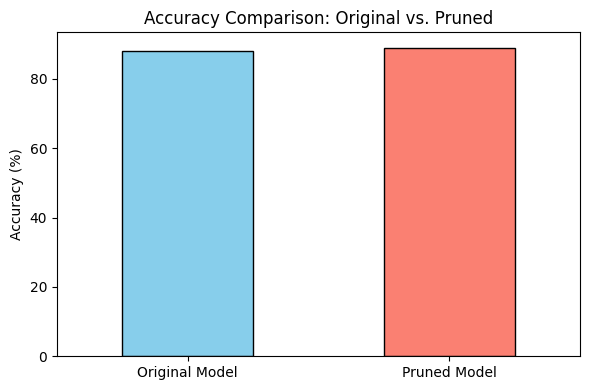

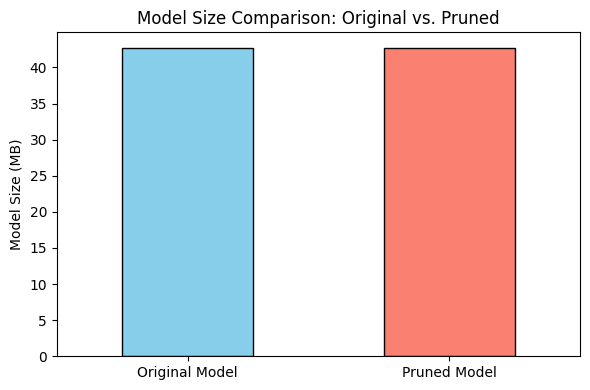

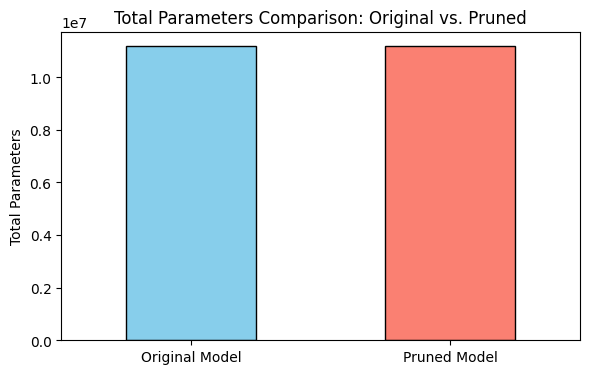

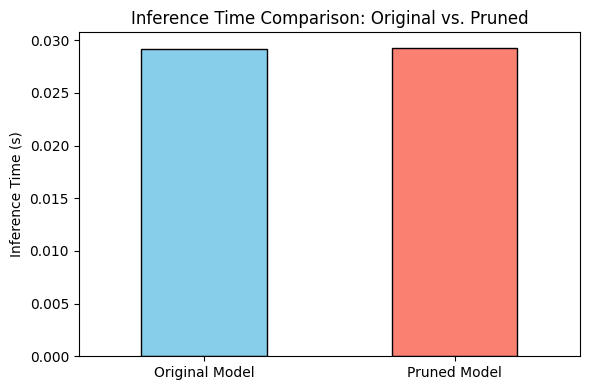

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import pandas as pd
import matplotlib.pyplot as plt
import time
from typing import List, Optional
from enum import Enum, auto
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load Pre-trained Model or Train if necessary
model_path = "model_original.pth"
if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
else:
    print("Training model...")
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    def train_model(model, epochs=5):
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    train_model(model, epochs=5)
    torch.save(model.state_dict(), model_path)

# Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Pruning Logic (Pruning classes)
class TraversalDirection(Enum):
    UP = auto()
    DOWN = auto()

class PruningType(Enum):
    DIRECT = auto()
    MASK = auto()
    AXIS_WISE = auto()

class BasePruning:
    def __init__(self, model: nn.Module):
        self.model = model
        self.original_state = {name: param.clone() for name, param in model.named_parameters()}

    def reset(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param.copy_(self.original_state[name])

class MaskChannelPruning(BasePruning):
    def __init__(self, model: nn.Module):
        super().__init__(model)
        self.masks = {}
        self._initialize_masks()

    def _initialize_masks(self):
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                self.masks[name] = torch.ones_like(param)

    def apply_mask(self, name: str, mask: torch.Tensor):
        param = dict(self.model.named_parameters())[name]
        param.data *= mask
        self.masks[name] = mask

    def prune_channels(self, layer_name: str, channels: List[int]):
        mask = self.masks[f"{layer_name}.weight"].clone()
        mask[channels] = 0
        self.apply_mask(f"{layer_name}.weight", mask)

class PruningMethod:
    def __init__(self, model: nn.Module, pruning_type: PruningType = PruningType.MASK):
        self.model = model
        if pruning_type == PruningType.MASK:
            self.pruner = MaskChannelPruning(model)

    def prune_percentage(self, percentage: float, layer_name: Optional[str] = None):
        assert 0 <= percentage <= 1, "Percentage must be between 0 and 1"
        for name, module in self.model.named_modules():
            if layer_name is not None and name != layer_name:
                continue
            if isinstance(module, nn.Conv2d):
                l1_norm = torch.norm(module.weight.data, p=1, dim=(1,2,3))
                num_channels = int(percentage * len(l1_norm))
                _, indices = torch.sort(l1_norm)
                channels_to_prune = indices[:num_channels].tolist()
                self.pruner.prune_channels(name, channels_to_prune)

def prune_model(model: nn.Module, pruning_type: PruningType = PruningType.MASK, percentage: float = 0.3) -> nn.Module:
    pruner = PruningMethod(model, pruning_type)
    pruner.prune_percentage(percentage)
    return model

# Metrics Calculation
def calculate_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth") / (1024 * 1024)  # Size in MB
    os.remove("temp.pth")
    return size

def measure_inference_time(model, data_loader, iterations=10):
    model.eval()
    inputs, _ = next(iter(data_loader))
    inputs = inputs.to(device)

    # Warm-up
    with torch.no_grad():
        for _ in range(5):
            model(inputs)

    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            model(inputs)
    total_time = time.time() - start_time
    return total_time / iterations

# Comparison
original_accuracy = evaluate_model(model, test_loader)
original_size = calculate_model_size(model)
original_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
original_inference_time = measure_inference_time(model, test_loader)

# Reduce pruning percentage to a smaller value, e.g., 0.2
pruned_model = prune_model(model, pruning_type=PruningType.MASK, percentage=0.2)


def fine_tune_model(model, train_loader, epochs=3, device=device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    return model


# Fine-tune the pruned model
pruned_model = fine_tune_model(pruned_model, train_loader, epochs=3)

# Re-evaluate the pruned model
pruned_accuracy = evaluate_model(pruned_model, test_loader)
pruned_size = calculate_model_size(pruned_model)
pruned_params = sum(p.numel() for p in pruned_model.parameters() if p.requires_grad)
pruned_inference_time = measure_inference_time(pruned_model, test_loader)

# Store numeric values for plotting
results = pd.DataFrame({
    "Metric": ["Accuracy (%)", "Model Size (MB)", "Total Parameters", "Inference Time (s)"],
    "Original Model": [original_accuracy, original_size, original_params, original_inference_time],
    "Pruned Model": [pruned_accuracy, pruned_size, pruned_params, pruned_inference_time]
})

# Apply formatting only for display/printing
results_display = results.copy()
results_display["Original Model"] = results_display["Original Model"].apply(lambda x: f"{x:.2f}")
results_display["Pruned Model"] = results_display["Pruned Model"].apply(lambda x: f"{x:.2f}")

# Print Results for display
print("\nFormatted Comparison Results:\n")
print(results_display)

# Plot each metric separately
metrics = results.set_index("Metric")

# Accuracy Plot
plt.figure(figsize=(6, 4))
metrics.loc["Accuracy (%)"].plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")
plt.title("Accuracy Comparison: Original vs. Pruned")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Model Size Plot
plt.figure(figsize=(6, 4))
metrics.loc["Model Size (MB)"].plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")
plt.title("Model Size Comparison: Original vs. Pruned")
plt.ylabel("Model Size (MB)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Total Parameters Plot
plt.figure(figsize=(6, 4))
metrics.loc["Total Parameters"].plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")
plt.title("Total Parameters Comparison: Original vs. Pruned")
plt.ylabel("Total Parameters")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Inference Time Plot
plt.figure(figsize=(6, 4))
metrics.loc["Inference Time (s)"].plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")
plt.title("Inference Time Comparison: Original vs. Pruned")
plt.ylabel("Inference Time (s)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
